In [1]:
import numpy as np
import librosa
import os
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pywt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, Input

In [2]:
# Path to your data folder, where heart sound .wav files are stored in class-wise folders
data_path =  'Data'# Change this to your actual data path


data = {
    'Mitral Stenosis (MS)': [],  
    'Mitral Regurgitation (MR)': [],  
    'Mitral Valve Prolapse (MVP)': [],  
    'Aortic Stenosis (AS)': [],  
    'Normal': []  
}

In [3]:
def extract_features(file_path):
    # List to store the extracted features
    features = []
    
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # 1. Log Mel Spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spect = librosa.power_to_db(mel_spect)
    features.append(np.mean(log_mel_spect, axis=1))

    # 2. MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs, axis=1))
    
    # 3. Delta and Delta-Delta (MFCC Derivatives)
    delta_mfcc = librosa.feature.delta(mfccs)
    delta_delta_mfcc = librosa.feature.delta(mfccs, order=2)
    features.append(np.mean(delta_mfcc, axis=1))
    features.append(np.mean(delta_delta_mfcc, axis=1))
    
    # 4. Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(y, 'db1', level=5)
    features.append(np.hstack([np.mean(c) for c in coeffs]))

    # 5. Chroma Feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))
    
    # 6. Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    
    # 7. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(spectral_centroid))
    
    # 8. Spectral Contrast (Dynamically adjusted)
    nyquist = sr / 2  # Nyquist frequency
    fmin = max(200.0, nyquist / 10)  # Ensure fmin is at least 200 Hz or 1/10th of the Nyquist
    n_bands = min(6, int(np.floor(np.log2(nyquist / fmin))))  # Adjust n_bands to not exceed Nyquist
    
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, fmin=fmin, n_bands=n_bands)
    features.append(np.mean(spectral_contrast, axis=1))
    
    # 9. Energy (RMS)
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))
    
    # 10. Temporal Flatness (Spectral Flatness)
    flatness = librosa.feature.spectral_flatness(y=y)
    features.append(np.mean(flatness))
    
    # Combine all features into a single array
    return np.hstack(features)


In [4]:
for label in data.keys():
    folder = os.path.join(data_path, label)
    features_list = []
    for file in glob.glob(folder + "/*.wav"):
        features = extract_features(file)
        if features.size > 0:
            features_list.append(features)
        else:
            print(f"No features extracted for file: {file}")
    data[label] = np.array(features_list)  # Convert to NumPy array

print("Feature extraction completed.")

c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature extraction completed.


In [5]:
# Combine all data into one dataset (X) and create labels (y)
X = np.vstack([data['Aortic Stenosis (AS)'], 
               data['Mitral Stenosis (MS)'], 
               data['Mitral Regurgitation (MR)'], 
               data['Mitral Valve Prolapse (MVP)'], 
               data['Normal']])

y = np.concatenate([[0]*len(data['Aortic Stenosis (AS)']),
                    [1]*len(data['Mitral Stenosis (MS)']),
                    [2]*len(data['Mitral Regurgitation (MR)']),
                    [3]*len(data['Mitral Valve Prolapse (MVP)']),
                    [4]*len(data['Normal'])])

print(f"Shape of X (feature matrix): {X.shape}")
print(f"Shape of y (labels): {y.shape}")


Shape of X (feature matrix): (1000, 193)
Shape of y (labels): (1000,)


In [8]:
X

array([[-6.98488712e+00, -6.59862375e+00,  3.81806254e-01, ...,
         1.51099080e+01,  1.77104130e-01,  4.59099095e-03],
       [-9.17411041e+00, -6.65122128e+00,  7.61975408e-01, ...,
         1.55059078e+01,  1.77820802e-01,  2.06775544e-03],
       [-8.15559578e+00, -6.33892536e+00,  1.05119681e+00, ...,
         1.52525163e+01,  1.77815810e-01,  2.19290867e-03],
       ...,
       [-1.86867447e+01, -1.20529079e+01, -7.24122715e+00, ...,
         1.63321329e+01,  4.25485559e-02,  6.68036612e-03],
       [-1.75773106e+01, -1.30530729e+01, -8.11293316e+00, ...,
         1.59884931e+01,  4.06117961e-02,  2.17265133e-02],
       [-2.08455467e+01, -1.60013580e+01, -1.15348330e+01, ...,
         1.56982979e+01,  3.39029543e-02,  9.04660206e-03]])

In [6]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_scaled

array([[ 1.29718872,  0.91240491,  0.72261913, ..., -0.25182398,
         2.33086439, -0.33116684],
       [ 0.91954728,  0.90434538,  0.768516  , ...,  0.04890338,
         2.34939367, -0.41633346],
       [ 1.09524125,  0.95219854,  0.80343298, ..., -0.14352544,
         2.3492646 , -0.41210917],
       ...,
       [-0.72138399,  0.07664405, -0.19769067, ...,  0.67634932,
        -1.14802043, -0.2606443 ],
       [-0.53000638, -0.07661139, -0.30292956, ...,  0.4153848 ,
        -1.19809465,  0.24720737],
       [-1.09377776, -0.5283776 , -0.71604698, ...,  0.19500684,
        -1.37154928, -0.18077688]])

In [9]:
#  Assuming you have X_data (features) and y_labels (labels)
X_train, X_test, y_train, y_test = train_test_split(
X_scaled, y, test_size=0.3, random_state=12, shuffle=True, stratify=y
)


In [10]:
# Reshape X_train for CNN + LSTM input
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Learning Rate Scheduler
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

# Define the CNN-LSTM Model
def create_cnn_lstm_model(input_shape, num_classes=5):
    inputs = layers.Input(shape=input_shape)
    
    # CNN Layers with Batch Normalization
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(128, (3, 1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    # Reshape for LSTM
    shape = x.shape
    time_steps = shape[1]
    features = shape[2] * shape[3]
    x = layers.Reshape((time_steps, features))(x)
    
    # LSTM Layer
    x = layers.LSTM(128, return_sequences=True, dropout=0.5)(x)
    
    # Global Average Pooling
    x = layers.GlobalMaxPooling1D()(x)  # Switched to GlobalMaxPooling1D

    # Fully Connected Layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Compile the model with learning rate scheduler
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)
model = create_cnn_lstm_model(input_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)




Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 193, 1, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 193, 1, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 193, 1, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 193, 1, 64)     │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 193, 1, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 96, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 96, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 96, 1, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 96, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 96, 1, 128)     │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 96, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 48, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 48, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 48, 1, 256)     │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 48, 1, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 48, 1, 256)     │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 48, 1, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 48, 1, 256)     │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 48, 1, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 24, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 24, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 797,765 (3.04 MB)

 Trainable params: 795,461 (3.03 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.2225 - loss: 2.5494 - val_accuracy: 0.2767 - val_loss: 2.4474
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.2648 - loss: 2.3801 - val_accuracy: 0.2000 - val_loss: 2.4336
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.3439 - loss: 2.3109 - val_accuracy: 0.2000 - val_loss: 2.4186
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.4172 - loss: 2.1895 - val_accuracy: 0.2000 - val_loss: 2.3853
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.4412 - loss: 2.0693 - val_accuracy: 0.2100 - val_loss: 2.3842
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.5171 - loss: 1.9659 - val_accuracy: 0.2000 - val_loss: 2.5310
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.5026 - loss: 1.9070 - val_accuracy: 0.2000 - val_loss: 2.4997
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.5320 - loss: 1.8033 - val_accu

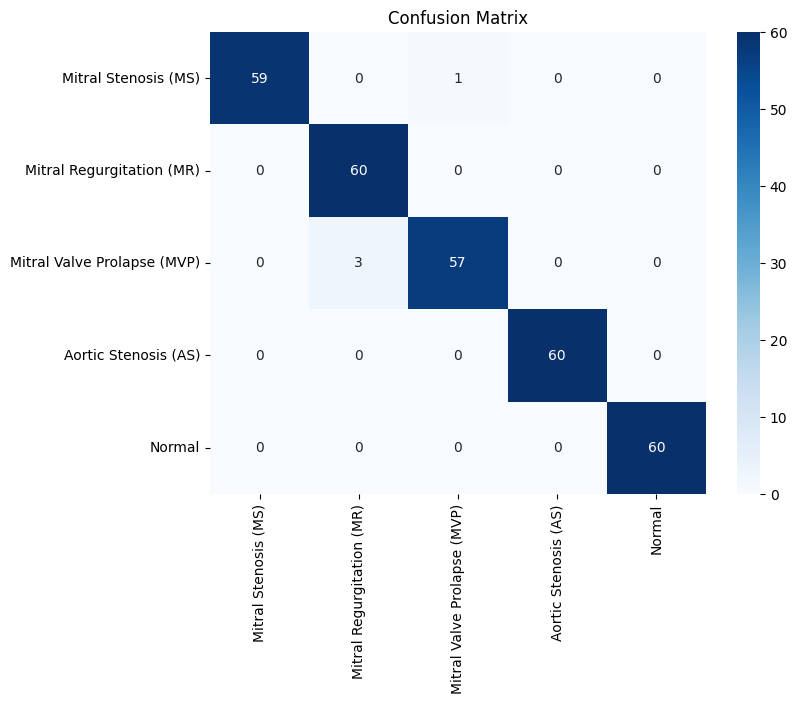

In [36]:
# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluate the model and print confusion matrix
y_pred = model.predict(X_test_reshaped)
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.keys(), yticklabels=data.keys())
plt.title("Confusion Matrix")
plt.show()


In [37]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

10/10 - 0s - 24ms/step - accuracy: 0.9867 - loss: 0.1526
Test Loss: 0.15258760750293732
Test Accuracy: 0.9866666793823242


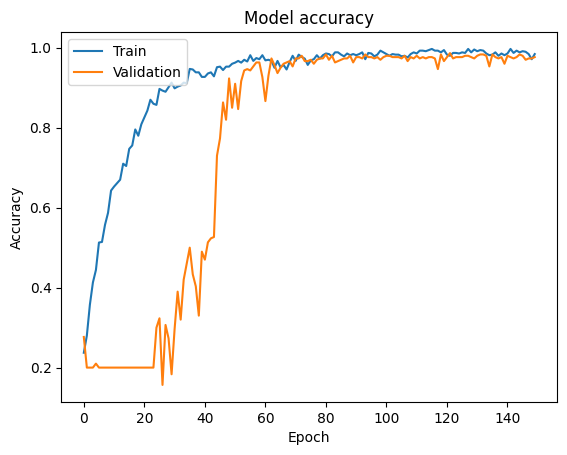

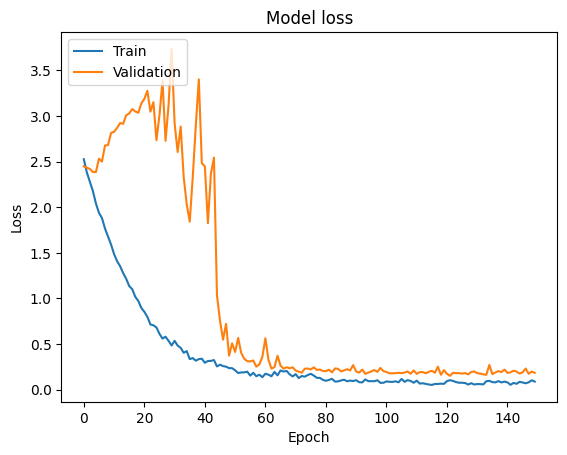

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Number of folds for Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# To store accuracy and loss for each fold
fold_accuracies = []
fold_losses = []

# Stratified K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"\n--- Fold {fold + 1} ---")
    
    # Split data into train and validation sets for this fold
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Reshape for CNN + LSTM input
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    
    # Create a new instance of the model for each fold
    model = create_advanced_cnn_lstm_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train_reshaped, y_train,
        validation_data=(X_val_reshaped, y_val),
        epochs=50,  # Set to a smaller number for quick testing, increase if needed
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    # Evaluate on the validation set for this fold
    val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val, verbose=2)
    fold_losses.append(val_loss)
    fold_accuracies.append(val_accuracy)
    
    print(f"Fold {fold + 1} - Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Print the final results after cross-validation
print(f"\n--- Cross-Validation Results ---")
print(f"Mean Validation Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Mean Validation Loss: {np.mean(fold_losses):.4f} ± {np.std(fold_losses):.4f}")



--- Fold 1 ---
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.2343 - loss: 3.0046 - val_accuracy: 0.2000 - val_loss: 2.0350
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2271 - loss: 2.8957 - val_accuracy: 0.2700 - val_loss: 2.0315
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3094 - loss: 2.4239 - val_accuracy: 0.1850 - val_loss: 2.0393
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3319 - loss: 2.3493 - val_accuracy: 0.1850 - val_loss: 2.0538
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3879 - loss: 2.1757 - val_accuracy: 0.1900 - val_loss: 2.0783
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4677 - loss: 1.9672 - val_accuracy: 0.1900 - val_loss: 2.1103
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4444 - loss: 2.0058 - val_accuracy: 0.1900 - val_loss: 2.1271
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5281 - loss: 1.8281 - val_accu

In [72]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 - 0s - 26ms/step - accuracy: 0.9933 - loss: 0.0601
Test Loss: 0.060107696801424026
Test Accuracy: 0.9933333396911621
